INSTALLING LIBRARIES

In [1]:
#!pip install chess

IMPORTING LIBRARIES

In [2]:
import chess
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

UTILITY FUNCTIONS

ENCODING THE BOARD

In [3]:
def parse_fen(fen):
    #print(fen)
    #not flipping the board for perspective since self-play is not required
    file_to_num = {'a': 1, 'b': 2, 'c': 3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8}
    enc = np.zeros([8,8,49]).astype(int)
    fen_elem = fen.split(' ')
    fen_pos = fen_elem[0]
    if fen_elem[1] == 'w':
        player = 1
        enc_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5, "r":6, "n":7, "b":8, "q":9, "k":10, "p":11}
    else:
        player = 0
        enc_dict = {"r":0, "n":1, "b":2, "q":3, "k":4, "p":5, "R":6, "N":7, "B":8, "Q":9, "K":10, "P":11}
    enc[:,:,12] = player
    castle = fen_elem[2]
    if player:
        if 'Q' not in castle:
            enc[:,:,13] = 1
        if 'K' not in castle:
            enc[:,:,14] = 1
        if 'q' not in castle:
            enc[:,:,15] = 1
        if 'k' not in castle:
            enc[:,:,16] = 1
    else:
        if 'Q' not in castle:
            enc[:,:,15] = 1
        if 'K' not in castle:
            enc[:,:,16] = 1
        if 'q' not in castle:
            enc[:,:,13] = 1
        if 'k' not in castle:
            enc[:,:,14] = 1
    #enc[:,:,17] = int(fen_elem[-1])
    ranks = fen_pos.split('/')
    for i, rank in enumerate(ranks):
        j = 0
        k = 0
        while k < len(rank):
            if rank[k].isdigit():
                j += int(rank[k])
                k += 1
                continue
            enc[(7 - i)*player + (1 - player)*i, j*player + (1 - player)*(7 - j), enc_dict[rank[k]]] = 1
            j += 1
            k += 1
    # appending the squares covered by pieces of both sides
    l = 17
    for j in range(2):
        pawns_sq = []
        if j == 1:
            fen = board.push(chess.Move.null())
        board = chess.Board(fen)
        legal_moves = board.legal_moves
        pieces = [enc_dict[str(board.piece_at(move.from_square))] for move in legal_moves]
        legal_moves_ordered = np.array(list(legal_moves))[np.argsort(pieces, kind = 'stable')]
        n = len(legal_moves_ordered)
        chg_dir = 1
        for i in range(n):
            move = legal_moves_ordered[i]
            move_str = str(move)
            initial_file = player*(file_to_num[move_str[0]] - 1) + (1 - player)*(8 - file_to_num[move_str[0]])
            initial_rank = player*(int(move_str[1]) - 1) + (1 - player)*(8 - int(move_str[1])) 
            from_sq = move.from_square
            if str(board.piece_at(from_sq)).upper() == 'P':
                if from_sq not in pawns_sq:
                    if str(board.piece_at(from_sq)) == 'P':
                        if initial_rank + 1 < 8 and initial_file - 1 >= 0:
                            enc[initial_rank + 1, initial_file - 1, l] = 1
                        if initial_rank + 1 < 8 and initial_file + 1 < 8:
                            enc[initial_rank + 1, initial_file + 1, l] = 1
                    else:
                        if initial_rank - 1 >= 0 and initial_file - 1 >= 0:
                            enc[initial_rank - 1, initial_file - 1, l] = 1
                        if initial_rank - 1 >= 0 and initial_file + 1 < 8:
                            enc[initial_rank - 1, initial_file + 1, l] = 1
#                     while i + 1 < n and legal_moves_ordered[i + 1].from_square == from_sq:
#                         i += 1
                    pawns_sq.append(from_sq)
                    l += 1
                    #print(str(move))
                continue
            if str(board.piece_at(from_sq)).upper() == 'N':
                if initial_file + 2 < 8 and initial_rank + 1 < 8:
                    enc[initial_rank + 1, initial_file + 2, l] = 1
                if initial_file + 2 < 8 and initial_rank - 1 >= 0:
                    enc[initial_rank - 1, initial_file + 2, l] = 1
                if initial_file + 1 < 8 and initial_rank + 2 < 8:
                    enc[initial_rank + 2, initial_file + 1, l] = 1
                if initial_file - 1 >= 0 and initial_rank + 2 < 8:
                    enc[initial_rank + 2, initial_file - 1, l] = 1
                if initial_file - 2 >= 0 and initial_rank + 1 < 8:
                    enc[initial_rank + 1, initial_file - 2, l] = 1
                if initial_file - 2 >= 0 and initial_rank - 1 >= 0:
                    enc[initial_rank - 1, initial_file - 2, l] = 1
                if initial_file - 1 >= 0 and initial_rank - 2 >= 0:
                    enc[initial_rank - 2, initial_file - 1, l] = 1
                if initial_file + 1 < 8 and initial_rank - 2 >= 0:
                    enc[initial_rank - 2, initial_file + 1, l] = 1
                while i + 1 < n and legal_moves_ordered[i + 1].from_square == from_sq:
                    i += 1
                l += 1
                #print(str(move))
                continue
            final_file = player*(file_to_num[move_str[2]] - 1) + (1 - player)*(8 - file_to_num[move_str[2]])
            final_rank = player*(int(move_str[3]) - 1) + (1 - player)*(8 - int(move_str[3]))
            if chg_dir:
                if not board.is_capture(move) and 0 <= final_rank + np.sign(final_rank - initial_rank) < 8 and 0 <= final_file + np.sign(final_file - initial_file) < 8:
                    enc[final_rank + np.sign(final_rank - initial_rank), final_file + np.sign(final_file - initial_file), l] = 1
                chg_dir = 0
            elif abs(final_rank - initial_rank) == 1 or abs(final_file - initial_file) == 1:
                chg_dir = 1
            enc[final_rank, final_file, l] = 1
            if i + 1 < n and legal_moves_ordered[i + 1].from_square != from_sq:
                w_sq = (initial_rank, initial_file - 1)
                e_sq = (initial_rank, initial_file + 1)
                n_sq = (initial_rank + 1, initial_file)
                s_sq = (initial_rank - 1, initial_file)
                ne_sq = (initial_rank + 1, initial_file + 1)
                nw_sq = (initial_rank + 1, initial_file - 1)
                se_sq = (initial_rank - 1, initial_file + 1)
                sw_sq = (initial_rank - 1, initial_file - 1)
                if str(board.piece_at(from_sq)).upper():
                    if w_sq[1] >= 0:
                        enc[w_sq[0], w_sq[1], l] = 1
                    if e_sq[1] < 8:
                        enc[e_sq[0], e_sq[1], l] = 1
                    if n_sq[0] < 8:
                        enc[n_sq[0], n_sq[1], l] = 1
                    if s_sq[0] >= 0:
                        enc[s_sq[0], s_sq[1], l] = 1
                elif str(board.piece_at(from_sq)).upper():
                    if ne_sq[0] < 8 and ne_sq[1] < 8:
                        enc[ne_sq[0], ne_sq[1], l] = 1
                    if nw_sq[0] < 8 and nw_sq[1] >= 0:
                        enc[nw_sq[0], nw_sq[1], l] = 1
                    if se_sq[0] >= 0 and se_sq[1] < 8:
                        enc[se_sq[0], se_sq[1], l] = 1
                    if sw_sq[0] >= 0 and sw_sq[1] >= 0:
                        enc[sw_sq[0], sw_sq[1], l] = 1
                else: #for king and queen all directions
                    if w_sq[1] >= 0:
                        enc[w_sq[0], w_sq[1], l] = 1
                    if e_sq[1] < 8:
                        enc[e_sq[0], e_sq[1], l] = 1
                    if n_sq[0] < 8:
                        enc[n_sq[0], n_sq[1], l] = 1
                    if s_sq[0] >= 0:
                        enc[s_sq[0], s_sq[1], l] = 1
                    if ne_sq[0] < 8 and ne_sq[1] < 8:
                        enc[ne_sq[0], ne_sq[1], l] = 1
                    if nw_sq[0] < 8 and nw_sq[1] >= 0:
                        enc[nw_sq[0], nw_sq[1], l] = 1
                    if se_sq[0] >= 0 and se_sq[1] < 8:
                        enc[se_sq[0], se_sq[1], l] = 1
                    if sw_sq[0] >= 0 and sw_sq[1] >= 0:
                        enc[sw_sq[0], sw_sq[1], l] = 1
                l += 1        
                #print(str(move))
    return enc

In [4]:
fen = 'r2qnrk1/pb1nbpp1/1p5p/2pp4/3P1B2/2NBPN1P/PPQ2PP1/R2R2K1 w - - 2 14'
#fen = '1r1q1rk1/4npbp/2npb1p1/pppNp3/2P5/3P2P1/PPNBPPBP/1R1Q1RK1 w - - 0 13'
b = chess.Board(fen)
enc_dict = {"R":0, "N":1, "B":2, "Q":3, "K":4, "P":5, "r":6, "n":7, "b":8, "q":9, "k":10, "p":11}
legal_moves = b.legal_moves
pieces = [enc_dict[str(b.piece_at(move.from_square))] for move in legal_moves]
legal_moves_ordered = np.array(list(legal_moves))[np.argsort(pieces, kind = 'stable')]
legal_moves_ordered

array([Move.from_uci('d1d2'), Move.from_uci('d1f1'),
       Move.from_uci('d1e1'), Move.from_uci('d1c1'),
       Move.from_uci('d1b1'), Move.from_uci('a1c1'),
       Move.from_uci('a1b1'), Move.from_uci('f3g5'),
       Move.from_uci('f3e5'), Move.from_uci('f3h4'),
       Move.from_uci('f3h2'), Move.from_uci('f3d2'),
       Move.from_uci('f3e1'), Move.from_uci('c3d5'),
       Move.from_uci('c3b5'), Move.from_uci('c3e4'),
       Move.from_uci('c3a4'), Move.from_uci('c3e2'),
       Move.from_uci('c3b1'), Move.from_uci('f4b8'),
       Move.from_uci('f4c7'), Move.from_uci('f4h6'),
       Move.from_uci('f4d6'), Move.from_uci('f4g5'),
       Move.from_uci('f4e5'), Move.from_uci('f4g3'),
       Move.from_uci('f4h2'), Move.from_uci('d3h7'),
       Move.from_uci('d3g6'), Move.from_uci('d3a6'),
       Move.from_uci('d3f5'), Move.from_uci('d3b5'),
       Move.from_uci('d3e4'), Move.from_uci('d3c4'),
       Move.from_uci('d3e2'), Move.from_uci('d3f1'),
       Move.from_uci('c2a4'), Move.from_uci('c

In [5]:
idx = np.argsort(pieces, kind = 'stable')
idx

array([38, 39, 40, 41, 42, 43, 44,  8,  9, 10, 11, 12, 13, 23, 24, 25, 26,
       27, 28,  0,  1,  2,  3,  4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 29, 30, 31, 32, 33, 34, 35, 36, 37, 45, 46, 47, 48, 49, 50,
       51, 52, 53], dtype=int64)

In [6]:
[str(move) for move in legal_moves]

['f4b8',
 'f4c7',
 'f4h6',
 'f4d6',
 'f4g5',
 'f4e5',
 'f4g3',
 'f4h2',
 'f3g5',
 'f3e5',
 'f3h4',
 'f3h2',
 'f3d2',
 'f3e1',
 'd3h7',
 'd3g6',
 'd3a6',
 'd3f5',
 'd3b5',
 'd3e4',
 'd3c4',
 'd3e2',
 'd3f1',
 'c3d5',
 'c3b5',
 'c3e4',
 'c3a4',
 'c3e2',
 'c3b1',
 'c2a4',
 'c2b3',
 'c2e2',
 'c2d2',
 'c2c1',
 'c2b1',
 'g1h2',
 'g1h1',
 'g1f1',
 'd1d2',
 'd1f1',
 'd1e1',
 'd1c1',
 'd1b1',
 'a1c1',
 'a1b1',
 'd4c5',
 'h3h4',
 'e3e4',
 'g2g3',
 'b2b3',
 'a2a3',
 'g2g4',
 'b2b4',
 'a2a4']

In [7]:
[str(move) for move in legal_moves_ordered]

['d1d2',
 'd1f1',
 'd1e1',
 'd1c1',
 'd1b1',
 'a1c1',
 'a1b1',
 'f3g5',
 'f3e5',
 'f3h4',
 'f3h2',
 'f3d2',
 'f3e1',
 'c3d5',
 'c3b5',
 'c3e4',
 'c3a4',
 'c3e2',
 'c3b1',
 'f4b8',
 'f4c7',
 'f4h6',
 'f4d6',
 'f4g5',
 'f4e5',
 'f4g3',
 'f4h2',
 'd3h7',
 'd3g6',
 'd3a6',
 'd3f5',
 'd3b5',
 'd3e4',
 'd3c4',
 'd3e2',
 'd3f1',
 'c2a4',
 'c2b3',
 'c2e2',
 'c2d2',
 'c2c1',
 'c2b1',
 'g1h2',
 'g1h1',
 'g1f1',
 'd4c5',
 'h3h4',
 'e3e4',
 'g2g3',
 'b2b3',
 'a2a3',
 'g2g4',
 'b2b4',
 'a2a4']

In [8]:
f = parse_fen(fen)

ENCODING THE ACTION

In [9]:
def parse_actions(move, fen):
    if fen.split(' ')[1] == 'w':
        player = 1
    else:
        player = 0
    enc = np.zeros([8,8,73]).astype(int)
    file_to_num = {'a': 1, 'b': 2, 'c': 3, 'd':4, 'e':5, 'f':6, 'g':7, 'h':8}
    init_file = file_to_num[move[0]]
    init_rank = int(move[1])
    final_file = file_to_num[move[2]]
    final_rank = int(move[3])
    under_promo = move[-1] if move[-1] in ['n', 'N', 'b', 'B', 'r', 'R'] else None
    file_diff = (init_file - final_file)*player + (final_file - init_file)*(1 - player)
    rank_diff = (init_rank - final_rank)*player + (final_rank - init_rank)*(1 - player)
    if under_promo is not None: #underpromotions
        if file_diff == 0: #no capture
            if under_promo in ['r', 'R']:
                idx = 64
            elif under_promo in ['b', 'B']:
                idx = 65
            else:
                idx = 66
        elif file_diff > 0: # left capture
            if under_promo in ['r', 'R']:
                idx = 67
            elif under_promo in ['b', 'B']:
                idx = 68
            else:
                idx = 69
        else: # right capture
            if under_promo in ['r', 'R']:
                idx = 70
            elif under_promo in ['b', 'B']:
                idx = 71
            else:
                idx = 72
    elif file_diff == 0: #NS direction
        if rank_diff < 0: #upward
            idx = -rank_diff - 1
        else: #downward
            idx = 6 + rank_diff
    elif rank_diff == 0: #EW direction
        if file_diff < 0: #right
            idx = 13 - file_diff
        else: #left
            idx = 20 + file_diff
    elif abs(file_diff) == abs(rank_diff): #diagonal moves
        if rank_diff < 0 and file_diff < 0: #NE
            idx = 27 - rank_diff
        elif rank_diff > 0 and file_diff > 0: #SW
            idx = 34 + rank_diff
        elif rank_diff < 0 and file_diff > 0: #NW
            idx = 41 + file_diff
        else: #SE
            idx = 48 + rank_diff
    elif file_diff == 1 and rank_diff == -2:
        idx = 56
    elif file_diff == -1 and rank_diff == -2:
        idx = 57
    elif file_diff == 2 and rank_diff == 1:
        idx = 58
    elif file_diff == 2 and rank_diff == -1:
        idx = 59
    elif file_diff == 1 and rank_diff == 2:
        idx = 60
    elif file_diff == -1 and rank_diff == 2:
        idx = 61
    elif file_diff == -2 and rank_diff == 1:
        idx = 62
    elif file_diff == -2 and rank_diff == -1:
        idx = 63
    #enc[init_file - 1, init_rank - 1, idx] = 1
    enc[(init_rank - 1)*player + (8 - init_rank)*(1 - player), (init_file - 1)*player + (8 - init_file)*(1 - player), idx] = 1
    #return enc, init_file, init_rank, idx
    return enc, (init_file - 1)*player + (8 - init_file)*(1 - player), (init_rank - 1)*player + (8 - init_rank)*(1 - player), idx

DECODING THE TENSOR OUTPUT

In [10]:
def decode_action(out_policy, fen):
    board = chess.Board(fen)
    legal_moves = list(board.legal_moves)
    legal_moves_str = np.array([str(move) for move in legal_moves])
    prob = np.zeros(len(legal_moves))
    for i, move in enumerate(legal_moves_str):
        _, x, y, z = parse_actions(move, fen) #x = file, y = rank
        #prob[i] = out_policy[x - 1, y - 1, z]
        #prob[i] = out_policy[y - 1, x - 1, z]
        prob[i] = out_policy[y, x, z]
    prob /= np.sum(prob)
    idx = prob.argsort()[::-1]
    prob = prob[idx]
    legal_moves_str = legal_moves_str[idx]
    policy_dict = {move: p for move, p in zip(legal_moves_str, prob)}
    best_move = legal_moves_str[0]
    return policy_dict, best_move

COLLECTING DATA FROM GRANDMASTER GAMES FOR TRAINING

In [11]:
fen = []
action = []
all_fen = []
pre_sum = []
game_nos = []
with open('move.txt', 'r') as fm:
    action = [line.strip() for line in fm.readlines()]
with open('all_fen.txt', 'r') as faf:
    all_fen = [line.strip() for line in faf.readlines()]
with open('fen.txt', 'r') as ff:
    fen = [line.strip() for line in ff.readlines()]
with open('game_nos.txt', 'r') as fg:
    game_nos = [int(line.strip()) for line in fg.readlines()]
# with open('pre_sum.txt', 'r') as fp:
#     pre_sum = [int(line.strip()) for line in fp.readlines()]
# with open('puzzle_fen.txt', 'r') as fpf:
#     fen += [line.strip() for line in fpf.readlines()]
# with open('puzzle_action.txt', 'r') as fpa:
#     action += [line.strip() for line in fpa.readlines()]
# for i in range(1, 11):
#     with open('fen_' + str(i) + '.txt', 'r') as ff:
#         fen += [line.strip() for line in ff.readlines()]

TRAIN-TEST SPLIT

In [12]:
indices = np.arange(len(fen))
ind_train, ind_test_val = train_test_split(indices, test_size = 0.3, shuffle = True, random_state = 42)
ind_test, ind_val = train_test_split(ind_test_val, test_size = 0.4, random_state = 0)

TRAIN DATA GENERATOR FUNCTION (MEMORY EFFICIENT)

In [13]:
# def data_generator(X, Y, batch_size, is_validation = False):
#     num_samples = len(X)
#     indices = np.arange(num_samples)

#     if is_validation:
#         data_indices = indices  # Use all data for validation
#     else:
#         np.random.shuffle(indices)  # Shuffle indices only for training data
#         data_indices = indices

#     while True:
#         for start in range(0, num_samples, batch_size):
#             batch_indices = data_indices[start: start + batch_size]
#             batch_X = [parse_fen(X[i]) for i in batch_indices]
#             batch_Y = [parse_actions(Y[i])[0] for i in batch_indices]
#             yield np.array(batch_X), np.array(batch_Y)

DATA GENERATOR WITH HISTORY INCLUDED

In [14]:
def data_generator(X, Y, indices, game_nos, pre_sum, all_fen, batch_size, is_validation = False, history = 3):
    # Here X and Y are the original data (before splitting)
    # total stack height = history + 1
    while True:
        for start in range(0, len(X), batch_size):
            batch_indices = indices[start: start + batch_size]
            if history > 0:
                batch_X = []
                for i in batch_indices:
                    board = chess.Board(X[i])
                    n_moves = board.fullmove_number
                    hash_id = pre_sum[game_nos[i]] + n_moves - 1
                    stack_height = 49*(history + 1)
                    stack_input = np.empty((8, 8, stack_height))
                    for j in range(history, -1, -1):
                        stack_input[:, :, 48*(history - j):48*(history + 1 - j)] = parse_fen(all_fen[hash_id - j])
                    batch_X.append(stack_input)
            else:
                batch_X = [parse_fen(X[i]) for i in batch_indices]               
            batch_Y = [parse_actions(Y[i], X[i])[0] for i in batch_indices]
            yield np.array(batch_X), np.array(batch_Y)

POLICY NETWORK

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Add
#from tensorflow.keras import backend as K

# Residual block
def residual_block(x, filters, kernel_size = (3, 3)):
    y = Conv2D(filters, kernel_size, padding = 'same', activation = 'relu')(x)
    y = Conv2D(filters, kernel_size, padding = 'same', activation = 'relu')(y)
    y = Conv2D(filters, kernel_size, padding = 'same', activation = 'relu')(y)
    return Add()([x, y])

# Define the neural network model with skip connections
input_layer = Input(shape = (8, 8, 49))

# Initial convolutional layer
conv1 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(input_layer)

# Stack of residual blocks
residual = residual_block(conv1, 128)
for _ in range(2):  # Add more residual blocks if needed
    residual = residual_block(residual, 128)

# Flatten the output and add fully connected layers
flatten = Flatten()(residual)
dense1 = Dense(512, activation = 'relu')(flatten)
output_layer = Dense(8*8*73, activation = 'softmax')(dense1)

# Reshape output to 8x8x73 tensor
reshaped_output = Reshape((8, 8, 73))(output_layer)

# Create the model
model = Model(inputs = input_layer, outputs = reshaped_output)

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8, 8, 49)]           0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 8, 8, 128)            56576     ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 128)            147584    ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 128)            147584    ['conv2d_1[0][0]']            
                                                                                              

#input layer
n_kernels = 128
kernel_size = 3
history = 0
activation = 'relu'
input_layer = tf.keras.layers.Input(shape = (8, 8, 49*(history + 1)))
conv1 = layers.Conv2D(n_kernels, kernel_size + 1, activation = activation, padding = 'same')(input_layer) #128 kernels/ filters, 3x3, Relu
conv2 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv1) #128 kernels/ filters, 3x3, Relu
conv3 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv2) #128 kernels/ filters, 3x3, Relu
conv4 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv3) #128 kernels/ filters, 3x3, Relu
conv5 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv4) #128 kernels/ filters, 3x3, Relu
conv6 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv5) #128 kernels/ filters, 3x3, Relu
conv7 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv6) #128 kernels/ filters, 3x3, Relu
conv8 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv7) #128 kernels/ filters, 3x3, Relu
conv9 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv8) #128 kernels/ filters, 3x3, Relu
conv10 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv9) #128 kernels/ filters, 3x3, Relu
conv11 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv10) #128 kernels/ filters, 3x3, Relu
conv12 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv11) #128 kernels/ filters, 3x3, Relu
conv13 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv12) #128 kernels/ filters, 3x3, Relu
conv14 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv13)
conv15 = layers.Conv2D(n_kernels, kernel_size, activation = activation, padding = 'same')(conv14)
#policy output layer
policy = layers.Conv2D(73, 1, activation = activation, padding = 'same')(conv15) #8X8X73 policy map
flat_policy = layers.Flatten()(policy)
soft_policy = layers.Activation('softmax')(flat_policy)
output_layer = tf.reshape(soft_policy, (-1, 8, 8, 73))
#create the model
model = models.Model(inputs = input_layer, outputs = output_layer)
#compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

TRAINING THE POLICY NETWORK

In [16]:
batch_size = 32
steps_per_epoch = len(ind_train) // batch_size
train_data_generator = data_generator(fen, action, ind_train, game_nos, pre_sum, all_fen, batch_size, history = 0)
val_batch_size = 32
val_steps_per_epoch = len(ind_val) // val_batch_size
val_data_generator = data_generator(fen, action, ind_val, game_nos, pre_sum, all_fen, val_batch_size, is_validation = True, history = 0)
model.fit(train_data_generator,
          epochs = 1,
          steps_per_epoch = steps_per_epoch,
          validation_data = val_data_generator,
          validation_steps = val_steps_per_epoch)
train_data_generator.close()
val_data_generator.close()

46385/46385 [==============================] - 13054s 281ms/step - loss: nan - accuracy: 0.4535 - val_loss: nan - val_accuracy: 0.9867


In [17]:
model.save('new_model_2.keras')

In [18]:
#model2 = tf.keras.models.load_model('gen_model_large_3.keras') #best model is gen_model_large_3.keras
model2 = tf.keras.models.load_model('new_model_2.keras')

In [19]:
# def play_best_move(model, fen):
#     enc_fen = parse_fen(fen)
#     out_policy = model.predict(np.array([enc_fen]))[0]
#     return out_policy, decode_action(out_policy, fen)

In [20]:
def play_best_move_hist(model, fen, history = 3):
    enc_fen = parse_fen(fen)
    stack_fen = np.tile(enc_fen, (1, 1, history + 1))
    out_policy = model.predict(np.array([stack_fen]))[0]
    return out_policy, decode_action(out_policy, fen)

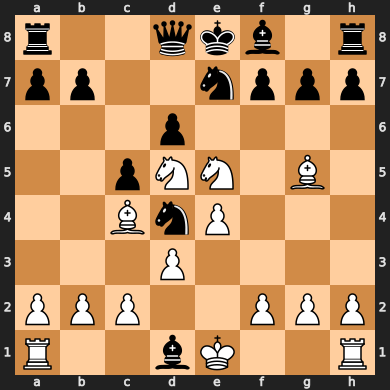

In [21]:
samp_fen = 'r2qkb1r/pp2nppp/3p4/2pNN1B1/2BnP3/3P4/PPP2PPP/R2bK2R w KQkq - 1 0'
b = chess.Board(samp_fen)
b

In [22]:
out, p = play_best_move_hist(model, samp_fen, history = 0)
p[0]

1/1 [==============================] - 0s 361ms/step


{'a2a4': nan,
 'd5c3': nan,
 'd5b4': nan,
 'd5f4': nan,
 'd5b6': nan,
 'd5f6': nan,
 'd5c7': nan,
 'd5e7': nan,
 'e5f3': nan,
 'e5g4': nan,
 'e5c6': nan,
 'e5g6': nan,
 'e5d7': nan,
 'e5f7': nan,
 'g5c1': nan,
 'g5d2': nan,
 'g5e3': nan,
 'g5f4': nan,
 'g5h4': nan,
 'g5f6': nan,
 'g5h6': nan,
 'd5e3': nan,
 'c4a6': nan,
 'b2b4': nan,
 'c4b5': nan,
 'f2f4': nan,
 'g2g4': nan,
 'h2h4': nan,
 'a2a3': nan,
 'b2b3': nan,
 'c2c3': nan,
 'f2f3': nan,
 'g2g3': nan,
 'h2h3': nan,
 'e1g1': nan,
 'a1b1': nan,
 'a1c1': nan,
 'a1d1': nan,
 'e1d1': nan,
 'e1f1': nan,
 'e1d2': nan,
 'h1f1': nan,
 'h1g1': nan,
 'c4b3': nan,
 'g5e7': nan}

SYSTEM SHUTDOWN AFTER EXECUTION

In [23]:
#model.save('model6.keras')

In [24]:
#import os
#os.system("shutdown /s /t 1") 